1.构建回归数据集，被拟合的函数定义为：

In [1]:
def linear_func(x,w=1.2,b=0.5):
    y=w*x+b
    return y

2.为了模拟真实环境中样本通常包含噪声的问题，我们采样过程中加入高斯噪声和异常点。

In [12]:
import torch

def create_toy_data(func, interval, sample_num, noise=0.0, add_outlier=False, outlier_ratio=0.001):
    """
    根据给定的函数，生成样本
    输入：
       - func：函数
       - interval： x的取值范围
       - sample_num： 样本数目
       - noise： 噪声均方差
       - add_outlier：是否生成异常值
       - outlier_ratio：异常值占比
    输出：
       - X: 特征数据，shape=[n_samples,1]
       - y: 标签数据，shape=[n_samples,1]
    """

    # 均匀采样
    # 使用torch.rand生成sample_num个随机数
    X = torch.rand(sample_num) * (interval[1] - interval[0]) + interval[0]
    y = func(X)
    print(X)
    print(y)
    print(y.shape)

    # 生成高斯分布的标签噪声
    # 使用torch.normal生成0均值，noise标准差的数据
    epsilon = torch.normal(mean=torch.zeros(y.shape[0]), std=noise)
    y = y + epsilon
    if add_outlier:     # 生成额外的异常点
        outlier_num = int(len(y) * outlier_ratio)
        if outlier_num != 0:
            # 使用torch.randperm生成一个从0到len(y)-1的随机排列，然后选择前outlier_num个作为outlier_idx
            outlier_idx = torch.randperm(len(y))[:outlier_num]
            y[outlier_idx] = y[outlier_idx] * 5
    return X.unsqueeze(1), y.unsqueeze(1)

3.利用以上功能，生成线性函数的训练集和测试集，并绘制图像。

tensor([ 4.3715,  2.4645,  6.2634, -5.2497,  6.6559,  9.0776, -2.2645, -3.7674,
        -8.3126, -2.3898,  0.1910, -3.6925, -2.2564,  2.2360,  4.0487,  8.7365,
         3.6831,  6.8344,  8.5586,  5.0642, -7.1782,  2.3666, -4.0454,  9.0720,
        -1.6823, -1.2696,  3.4151, -7.5534, -9.7362, -4.2819,  1.0375, -0.1566,
         2.5358,  7.4561,  0.6974, -2.2540, -2.5624, -4.2246, -7.1816, -4.3048,
        -6.6303,  2.6405, -3.9519, -6.4692, -9.2837,  9.3087,  4.9887, -9.6372,
        -7.3658,  1.0523, -0.9211,  1.8994,  6.1561, -8.8264,  1.2848, -7.9139,
         0.9628, -8.1602, -6.3391,  0.8997,  9.5533, -2.0807, -3.7582,  0.0588,
         2.9632,  2.7428, -4.0802, -9.7128,  5.2484, -9.2078, -1.9843,  9.8192,
        -8.8843, -3.9045,  2.7941, -0.5871,  2.9619, -2.5700, -6.2220,  8.4693,
         4.7252, -7.7455,  2.6162, -1.5015,  4.7167,  8.2034,  4.7604, -1.4438,
        -9.4366, -4.3968,  9.6115, -0.4594, -6.1809, -6.8806,  9.4548,  5.3029,
        -5.6092,  8.3139, -5.9117,  0.42

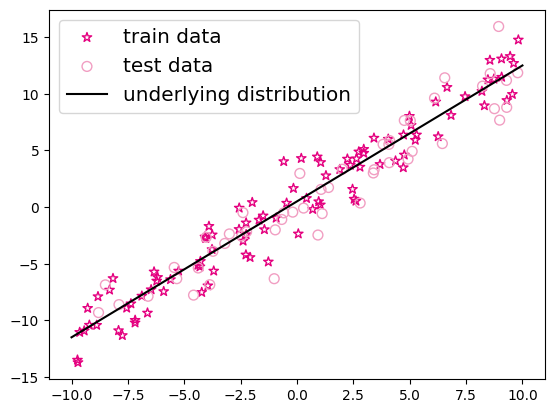

In [3]:
from matplotlib import pyplot as plt

func = linear_func
interval = (-10,10)
train_num = 100
test_num = 50
noise = 2
X_train,y_train = create_toy_data(func=func,interval=interval,sample_num=train_num,noise=noise,add_outlier=False)
X_test,y_test = create_toy_data(func=func,interval=interval,sample_num=test_num,noise=noise,add_outlier=False)

X_train_large,y_train_large = create_toy_data(func=func,interval=interval,sample_num=5000,noise=noise,add_outlier=True)

X_underlying = torch.linspace(interval[0],interval[1],train_num)
y_underlying = linear_func(X_underlying)

plt.scatter(X_train, y_train, marker='*', facecolor="none", edgecolor='#e4007f', s=50, label="train data")
plt.scatter(X_test, y_test, facecolor="none", edgecolor='#f19ec2', s=50, label="test data")
plt.plot(X_underlying, y_underlying, c='#000000', label=r"underlying distribution")
plt.legend(fontsize='x-large') # 给图像加图例
plt.savefig('ml-vis.pdf') # 保存图像到PDF文件中
plt.show()

4.构建线性回归模型

In [13]:
import torch
from torch.nn import Module

torch.manual_seed(10)  # 设置随机种子

# 线性算子
class Linear(Module):
    def __init__(self, input_size):
        self.params = {'w': None, 'b': None}
        """
        输入：
           - input_size: 模型要处理的数据特征向量长度
        """
        super(Linear, self).__init__()
        self.input_size = input_size

        # 模型参数
        self.params['w'] = torch.randn(input_size, 1, dtype=torch.float32, requires_grad=True)
        self.params['b'] = torch.zeros(1, dtype=torch.float32, requires_grad=True)

    def forward(self, X):
        """
        输入：
           - X: tensor, shape=[N, D]
           注意这里的X矩阵是由N个x向量的转置拼接成的，与原教材行向量表示方式不一致
        输出：
           - y_pred： tensor, shape=[N]
        """
        N, D = X.shape

        if self.input_size == 0:
            return torch.full((N, 1), fill_value=self.b.item())

        assert D == self.input_size, "输入数据维度不匹配"

        # 使用torch.matmul计算两个tensor的乘积
        y_pred = torch.matmul(X, self.params['w']) + self.params['b']

        return y_pred.squeeze()

# 设置输入大小和样本数量
input_size = 3
N = 2

# 生成2个维度为3的数据
X = torch.randn(N, input_size, dtype=torch.float32)

# 创建模型
model = Linear(input_size)

# 前向传播
y_pred = model.forward(X)

print("y_pred:", y_pred)  # 输出结果的个数也是2个

y_pred: tensor([1.8529, 0.6011], grad_fn=<SqueezeBackward0>)


5.定义损失函数

In [34]:
import torch

def mean_squared_error(y_true, y_pred):
    """
    输入：
       - y_true: tensor，样本真实标签
       - y_pred: tensor, 样本预测标签
    输出：
       - error: float，误差值
    """

    assert y_true.shape == y_pred.shape, "形状不匹配"

    # torch.square 计算输入的平方值
    # torch.mean 沿 axis 计算 x 的平均值，默认axis是None，则对输入的全部元素计算平均值。
    error = torch.mean(torch.square(y_true - y_pred))

    return error.item()


# 构造一个简单的样例进行测试:[N,1], N=2
y_true = torch.tensor([[-0.2], [4.9]], dtype=torch.float32)
y_pred = torch.tensor([[1.3], [2.5]], dtype=torch.float32)

error = mean_squared_error(y_true=y_true, y_pred=y_pred)
print("error:", error)

error: 4.005000114440918


6.优化模型参数

In [35]:
import torch

class LinearModel:
    def __init__(self):
        self.params = {'w': None, 'b': None}

def optimizer_lsm(model, X, y, reg_lambda=0):
    """
    输入：
       - model: 模型
       - X: tensor, 特征数据，shape=[N,D]
       - y: tensor, 标签数据，shape=[N]
       - reg_lambda: float, 正则化系数，默认为0
    输出：
       - model: 优化好的模型
    """

    N, D = X.shape

    # 对输入特征数据所有特征向量求平均
    x_bar = torch.mean(X, dim=0).T
    
    # 求标签的均值, shape=[1]
    y_bar = torch.mean(y)
    
    # 通过广播的方式实现矩阵减向量
    x_sub = X - x_bar.view(1, -1)
    
    # 检查 x_sub 是否全为0
    if torch.all(x_sub == 0):
        model.params['b'] = y_bar
        model.params['w'] = torch.zeros(D)
        return model
    
    # 求方阵的逆
    tmp = torch.inverse(torch.matmul(x_sub.mT, x_sub) + 
                        reg_lambda * torch.eye(D))
    
    # 计算 w
    w = torch.matmul(torch.matmul(tmp, x_sub.mT), (y - y_bar))
    
    # 计算 b
    b = y_bar - torch.matmul(x_bar, w)
    
    model.params['b'] = b
    model.params['w'] = w.squeeze(axis=-1)
    
    return model

7.模型预测

In [36]:
input_size = 1
model = Linear(input_size)
model = optimizer_lsm(model,X_train, y_train, reg_lambda=0.1)

print("w_pred:", model.params['w'].item(), "b_pred:", model.params['b'].item())
y_train_pred = model.forward(X_train.reshape([-1,1])).reshape([-1,1])

print("y_train_pred:", y_train_pred.shape) # 打印预测值和真实值的形状
print('y_train:',y_train.shape)

train_error = mean_squared_error(y_true=y_train, y_pred=y_train_pred)
print("train error: ",train_error)

w_pred: 1.2192754745483398 b_pred: 0.4761868715286255
y_train_pred: torch.Size([100, 1])
y_train: torch.Size([100, 1])
train error:  2.7519567012786865


****
动手练习:

为了加深对机器学习模型的理解，请自己动手完成以下实验：

（1） 调整训练数据的样本数量，由 100 调整到 5000，观察对模型性能的影响。

（2） 调整正则化系数，观察对模型性能的影响。
****

In [39]:

model_large = Linear(input_size)
model_large = optimizer_lsm(model_large,X_train_large, y_train_large, reg_lambda=0.1)

print("w_pred:", model_large.params['w'].item(), "b_pred:", model_large.params['b'].item())
y_train_pred_large = model_large(X_train_large.reshape([-1,1])).reshape([-1,1])

print("y_train_pred_large:", y_train_pred_large.shape) # 打印预测值和真实值的形状
print('y_train_large:',y_train_large.shape)

train_error_large = mean_squared_error(y_true=y_train_large, y_pred=y_train_pred_large)
print("train error: ",train_error_large)

w_pred: 1.1939046382904053 b_pred: 0.5297477841377258
y_train_pred_large: torch.Size([5000, 1])
y_train_large: torch.Size([5000, 1])
train error:  4.784622669219971
